In [ ]:
from google.colab import files

# Move the kaggle.json file to the right directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

!unzip recyclable-and-household-waste-classification.zip -d waste_dataset


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
recyclable-and-household-waste-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  recyclable-and-household-waste-classification.zip
replace waste_dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_dir = "./waste_dataset/images/images"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

class_names = dataset.classes
print(f"Class names: {class_names}")

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Class names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


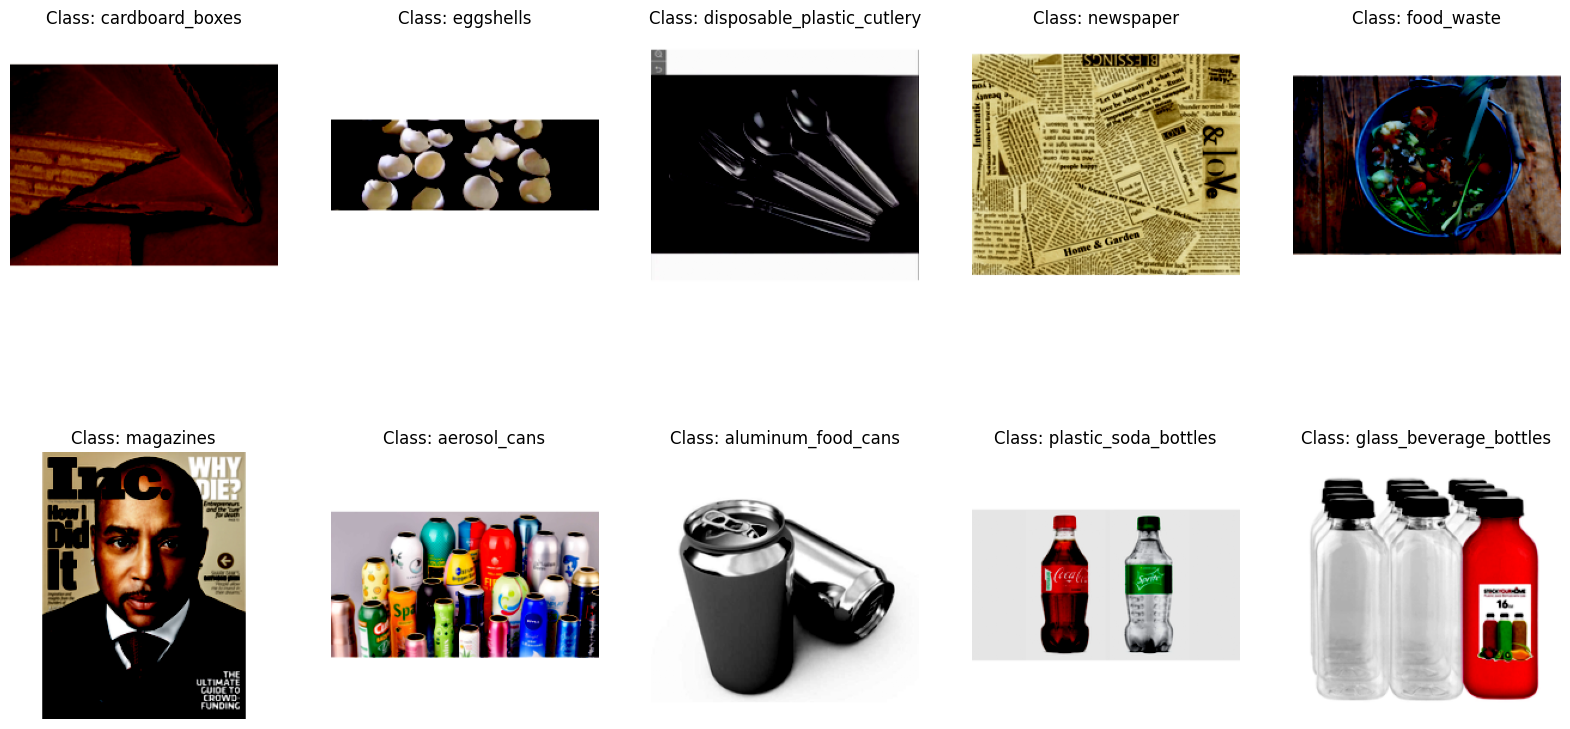

In [ ]:
import torchvision.datasets as dset
from PIL import Image
import matplotlib.pyplot as plt
import random
from torchvision.datasets import ImageFolder

dataset = ImageFolder(data_dir)

plt.figure(figsize=(20, 10))

for i in range(10):
    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    augmented_image = transform(image)

    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_image.permute(1, 2, 0))
    plt.title(f"Class: {dataset.classes[label]}")
    plt.axis("off")

In [ ]:
import torch
import torch.nn as nn

class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, anneal_coeff=None, anneal_epoch=None):
    loss_history = []
    train_history = []
    val_history = []

    if anneal_coeff and anneal_epoch:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            _, indices = torch.max(prediction, 1)

            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

    accuracy = float(correct_samples) / total_samples
    return accuracy

In [ ]:
train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.571679, Train accuracy: 0.540381, Val accuracy: 0.557778
Average loss: 0.991221, Train accuracy: 0.693429, Val accuracy: 0.633333
Average loss: 0.698026, Train accuracy: 0.776381, Val accuracy: 0.700889
Average loss: 0.532077, Train accuracy: 0.828476, Val accuracy: 0.712000
Average loss: 0.455369, Train accuracy: 0.840286, Val accuracy: 0.708000


([1.5716785192489624,
  0.9912213087081909,
  0.6980258226394653,
  0.5320773720741272,
  0.4553694725036621],
 [0.5403809523809524,
  0.6934285714285714,
  0.7763809523809524,
  0.8284761904761905,
  0.8402857142857143],
 [0.5577777777777778, 0.6333333333333333, 0.7008888888888889, 0.712, 0.708])

In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))

evaluate_model(model, test_loader)

              precision    recall  f1-score   support

           0       0.92      0.74      0.82        62
           1       0.36      0.37      0.36        73
           2       0.73      0.70      0.72        63
           3       0.62      0.37      0.46        63
           4       0.48      0.66      0.56        74
           5       0.52      0.79      0.63        63
           6       0.85      0.85      0.85        65
           7       1.00      0.64      0.78        78
           8       0.75      0.99      0.85        81
           9       0.72      0.84      0.78        83
          10       0.62      0.88      0.73        78
          11       0.94      0.73      0.82        83
          12       0.77      0.78      0.78        73
          13       0.85      0.82      0.84        97
          14       0.75      0.73      0.74        78
          15       0.72      0.49      0.58        96
          16       0.79      0.69      0.74        71
          17       0.71    

In [ ]:
class EnhancedResNet(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(EnhancedResNet, self).__init__()
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(pretrained_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return x

enhanced_model = EnhancedResNet(model, num_classes).to(device)
optimizer = torch.optim.Adam(enhanced_model.parameters(), lr=0.0001)

In [ ]:
train_model(enhanced_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.055853, Train accuracy: 0.786000, Val accuracy: 0.807111
Average loss: 0.189688, Train accuracy: 0.943429, Val accuracy: 0.819556
Average loss: 0.123070, Train accuracy: 0.957619, Val accuracy: 0.814667
Average loss: 0.100828, Train accuracy: 0.963238, Val accuracy: 0.816889
Average loss: 0.087163, Train accuracy: 0.967619, Val accuracy: 0.817333


([1.055853009223938,
  0.18968833982944489,
  0.12307026237249374,
  0.10082848370075226,
  0.08716341853141785],
 [0.786,
  0.9434285714285714,
  0.9576190476190476,
  0.9632380952380952,
  0.9676190476190476],
 [0.8071111111111111,
  0.8195555555555556,
  0.8146666666666667,
  0.8168888888888889,
  0.8173333333333334])

In [ ]:
evaluate_model(enhanced_model, test_loader)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90        62
           1       0.54      0.44      0.48        73
           2       0.74      0.89      0.81        63
           3       0.54      0.79      0.64        63
           4       0.65      0.47      0.55        74
           5       0.81      0.87      0.84        63
           6       0.92      0.91      0.91        65
           7       0.95      0.90      0.92        78
           8       0.90      0.98      0.93        81
           9       0.88      0.94      0.91        83
          10       0.79      0.90      0.84        78
          11       0.95      0.90      0.93        83
          12       0.92      0.90      0.91        73
          13       0.92      0.95      0.93        97
          14       0.82      0.83      0.83        78
          15       0.81      0.81      0.81        96
          16       0.87      0.82      0.84        71
          17       0.85    